Section 1: Import libraries

In [32]:
!pip install tensorflow

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.losses import MeanSquaredError
from sklearn.metrics import r2_score

Section 2: Load data

In [ ]:
data = pd.read_csv('data.csv')

In [ ]:
data.head()

,Data.Precipitation,Date.Full,Date.Month,Date.Week of,Date.Year,Station.City,Station.Code,Station.Location,Station.State,Data.Temperature.Avg Temp,Data.Temperature.Max Temp,Data.Temperature.Min Temp,Data.Wind.Direction,Data.Wind.Speed
0,0.00,2016-01-03,1,3,2016,Birmingham,BHM,"Birmingham, AL",Alabama,39,46,32,33,4.33
1,0.00,2016-01-03,1,3,2016,Huntsville,HSV,"Huntsville, AL",Alabama,39,47,31,32,3.86
2,0.16,2016-01-03,1,3,2016,Mobile,MOB,"Mobile, AL",Alabama,46,51,41,35,9.73
3,0.00,2016-01-03,1,3,2016,Montgomery,MGM,"Montgomery, AL",Alabama,45,52,38,32,6.86
4,0.01,2016-01-03,1,3,2016,Anchorage,ANC,"Anchorage, AK",Alaska,34,38,29,19,7.80


Section 3: Preprocessing

In [ ]:
train_data = data[(data['Date.Year'] >= 2016) & (data['Date.Year'] <= 2017)][['Date.Month', 'Data.Temperature.Max Temp', 'Data.Wind.Speed', 'Data.Precipitation']]
test_data = data[(data['Date.Year'] == 2017)][['Date.Month', 'Data.Temperature.Max Temp', 'Data.Wind.Speed', 'Data.Precipitation']]
mean = train_data.mean()
std = train_data.std()
train_data = (train_data - mean) / std
test_data = (test_data - mean) / std
n_steps = 7
batch_size = 64
train_samples = len(train_data) - n_steps
test_samples = len(test_data) - n_steps

Section 4: Create data generator

In [ ]:
train_data_gen = keras.preprocessing.timeseries_dataset_from_array(
    train_data[['Date.Month', 'Data.Temperature.Max Temp', 'Data.Wind.Speed']].values,
    train_data['Data.Precipitation'].values,
    sequence_length=n_steps,
    batch_size=batch_size
)
test_data_gen = keras.preprocessing.timeseries_dataset_from_array(
    test_data[['Date.Month', 'Data.Temperature.Max Temp', 'Data.Wind.Speed']].values,
    test_data['Data.Precipitation'].values,
    sequence_length=n_steps,
    batch_size=batch_size
)

Section 5: Define model

In [27]:
model = keras.Sequential([
    keras.layers.Input(shape=(n_steps, len(train_data.columns) - 1)),
    keras.layers.LSTM(64),
    keras.layers.Dense(1)
])

In [28]:
model

<Sequential name=sequential_1, built=True>

Section 6: Compile model

In [29]:
model.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=['mae'])

Section 7: Train model

In [30]:
model.fit(train_data_gen, epochs=100, batch_size=batch_size)

Epoch 1/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.9218 - mae: 0.6141
Epoch 2/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9119 - mae: 0.6059
Epoch 3/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9137 - mae: 0.6089
Epoch 4/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9102 - mae: 0.6128
Epoch 5/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9009 - mae: 0.6049
Epoch 6/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9107 - mae: 0.6078
Epoch 7/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8897 - mae: 0.6005
Epoch 8/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8855 - mae: 0.5972
Epoch 9/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8767 - mae: 0.5983
Epoch 10/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8712 - mae: 0.5936
Epoch 11/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8767 - mae: 0.5920
Epoch 12/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8519 - mae: 0.5833
Epoch 13/100


Section 8: Test model and print results

In [33]:
X_test = np.array([test_data.values[i:i+n_steps,:-1] for i in range(test_samples)])
y_true = test_data[n_steps:]['Data.Precipitation'].values.reshape(-1, 1)
y_pred = model.predict(X_test)

mse = tf.keras.losses.MeanSquaredError()(y_true, y_pred).numpy()
mae = tf.keras.losses.MeanAbsoluteError()(y_true, y_pred).numpy()
r2 = r2_score(y_true, y_pred)

print('MSE: ', mse)
print('MAE: ', mae)
print('R-squared: ', r2)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
MSE:  0.5740909
MAE:  0.5678903
R-squared:  -0.3580242023473994


Section 9: Plot true vs predicted precipitation values

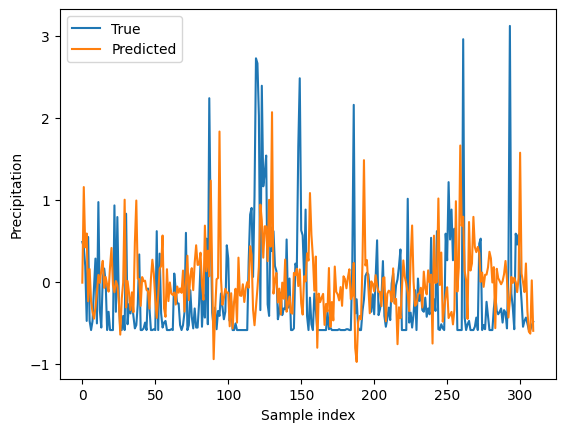

In [34]:
plt.plot(y_true, label='True')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Sample index')
plt.ylabel('Precipitation')
plt.legend()
plt.show()